In [142]:
import pandas as pd
import matplotlib as plt
import numpy as np

%matplotlib inline

In [143]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [144]:
empty_percent = train.apply(pd.isnull, axis = 0).sum() / train.shape[0] * 100
empty_percent.sort_values(ascending=False)

OutcomeSubtype    50.925961
Name              28.773991
AgeuponOutcome     0.067343
SexuponOutcome     0.003741
Color              0.000000
Breed              0.000000
AnimalType         0.000000
OutcomeType        0.000000
DateTime           0.000000
AnimalID           0.000000
dtype: float64

In [145]:
def transform_dates(val):
#     print(float(val.split(" ")[0]) * 365)
#     print(val)
    num_val = float(val.split(" ")[0])
    if "year" in val:
        return num_val * 365
    elif "month" in val:
        return num_val * 31
    elif "week" in val:
        return num_val * 7


def transform_dataset(df, columns_to_dropna=["AgeuponOutcome", "SexuponOutcome"]):
    result = df.dropna(subset=columns_to_dropna, axis=0)
    result.loc[:, "AgeuponOutcome"] = result.loc[:, "AgeuponOutcome"].apply(transform_dates)
    # result.drop(\"Name\")
    return result

train["Train"] = True
test["Train"] = False
train.drop('AnimalID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

dataset = pd.concat([train, test])
dataset = transform_dataset(dataset)
# dataset.drop(['AnimalID', 'ID'], axis=1, inplace=True)
# test_t = transform_dataset(test)
dataset.head(3)

/home/kdubovikov/opt/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,AgeuponOutcome,AnimalType,Breed,Color,DateTime,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,Train
0,365.0,Dog,Shetland Sheepdog Mix,Brown/White,2014-02-12 18:22:00,Hambone,NaN,Return_to_owner,Neutered Male,True
1,365.0,Cat,Domestic Shorthair Mix,Cream Tabby,2013-10-13 12:44:00,Emily,Suffering,Euthanasia,Spayed Female,True
2,730.0,Dog,Pit Bull Mix,Blue/White,2015-01-31 12:28:00,Pearce,Foster,Adoption,Neutered Male,True


We want to split all mixed breeds. Breed column contains a low number of strings like "Black/Tan Hound Mix" so we will remove colors fom those so we can split all values as we wish

In [146]:
import re

# First we remove "Mix" from all breeds and add additional categorical variable to the dataset
dataset["Mix"] = False
dataset.loc[dataset["Breed"].str.contains("Mix"), "Mix"] = True
breeds = dataset["Breed"].apply(lambda x: x.split(" Mix")[0])

# Next we remove all of the colors which cause problems when we try to split mixed breeds 
breeds = breeds.apply(lambda x: re.sub('Black\s?|Tan\s?', '', x))

# After that let's remove dirty substrings left from previous replacements
breeds = breeds.apply(lambda x: re.sub('^/', '', x))
breeds = breeds.str.replace("//", "")

# Finally, lets split the breeds and modify out dataset
breeds = breeds.apply(lambda x: pd.Series(x.split("/")))
breeds.columns = ['Breed', 'SecondaryBreed']

dataset.drop('Breed', inplace=True, axis = 1)
dataset = dataset.join(breeds)

In [147]:
# dataset.reset_index(inplace=True)
dataset.head(3)

,AgeuponOutcome,AnimalType,Color,DateTime,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,Train,Mix,Breed,SecondaryBreed
0,365.0,Dog,Brown/White,2014-02-12 18:22:00,Hambone,NaN,Return_to_owner,Neutered Male,True,True,Shetland Sheepdog,NaN
0,365.0,Dog,Brown/White,2014-02-12 18:22:00,Hambone,NaN,Return_to_owner,Neutered Male,True,True,Labrador Retriever,NaN
0,310.0,Dog,Red/White,2015-10-12 12:15:00,Summer,NaN,NaN,Intact Female,False,True,Shetland Sheepdog,NaN


Now we split DateTime to several features

In [148]:
from datetime import *

dates = dataset['DateTime'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

def time_of_day(hour):
    if hour > 7 and hour <= 11:
        return "morning"
    elif hour > 11 and hour <= 18:
        return "day"
    elif hour > 18 and hour <= 22:
        return "evening"
    else:
        return "night"

dataset["Year"] = dates.apply(lambda x: x.year)
dataset["Month"] = dates.apply(lambda x: x.month)
dataset["TimeOfDay"] = dates.apply(lambda x: time_of_day(x.hour))
dataset.drop("DateTime", axis=1, inplace=True)

Name can be converted to HasName categorical feature which will be more useful

In [149]:
dataset['HasName'] = dataset['Name'].isnull()
dataset.drop(['Name', 'OutcomeSubtype'], axis=1, inplace=True)

There will probaby be way to much features for colors, so we will transform them too

In [151]:
pd.value_counts(dataset['Color']).shape

(411,)

57 + 47 categorical features instead of 411, nice improvement

In [152]:
split_colors = pd.DataFrame(dataset['Color'].str.split('/').tolist(), columns=["Color1", "Color2"])
dataset.drop('Color', axis = 1, inplace=True)
dataset = dataset.join(split_colors)

len(split_colors['Color1'].unique()), len(split_colors['Color2'].unique())

(57, 47)

In [165]:
pd.DataFrame(dataset['SexuponOutcome'].str.split(" ").tolist(), columns=["Sterialized", "Sex"])

,Sterialised,Sex
0,Neutered,Male
1,Neutered,Male
2,Intact,Female
3,Intact,Female
4,Spayed,Female
5,Spayed,Female
6,Spayed,Female
7,Spayed,Female
8,Neutered,Male
9,Neutered,Male


In [156]:
cols = dataset.columns.difference(["Name", "AgeuponOutcome", "OutcomeType", "index", "Mix", "Month", "Train", "Year", "level_0"])
dataset_d = pd.get_dummies(dataset, columns = cols)
dataset_d.head(3)

,AgeuponOutcome,OutcomeType,Train,Mix,Year,Month,AnimalType_Cat,AnimalType_Dog,Breed_Abyssinian,Breed_Affenpinscher,...,SecondaryBreed_Yorkshire Terrier,SexuponOutcome_Intact Female,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,TimeOfDay_day,TimeOfDay_evening,TimeOfDay_morning,TimeOfDay_night
0,365.0,Return_to_owner,True,True,2014,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0,365.0,Return_to_owner,True,True,2014,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0,310.0,NaN,False,True,2015,10,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [158]:
# dataset_d.drop(['index'], axis=1, inplace=True)
dataset_d.loc[:, dataset_d.columns.str.contains("OutcomeType")].head(1)

,OutcomeType
0,Return_to_owner


In [159]:
import xgboost as xgb
from sklearn import preprocessing

train = dataset_d[dataset['Train'] == True]
test = dataset_d[dataset['Train'] == False]

train.drop('Train', axis=1, inplace=True)

# outcome_cols = ['OutcomeType_Adoption', 'OutcomeType_Died', 'OutcomeType_Euthanasia', 'OutcomeType_Return_to_owner', 'OutcomeType_Transfer']
train_x = train.loc[:, train.columns.difference(["OutcomeType"])]
train_y = train.loc[:, "OutcomeType"]

cf = xgb.XGBClassifier()
cf.fit(train_x, train_y)

/home/kdubovikov/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

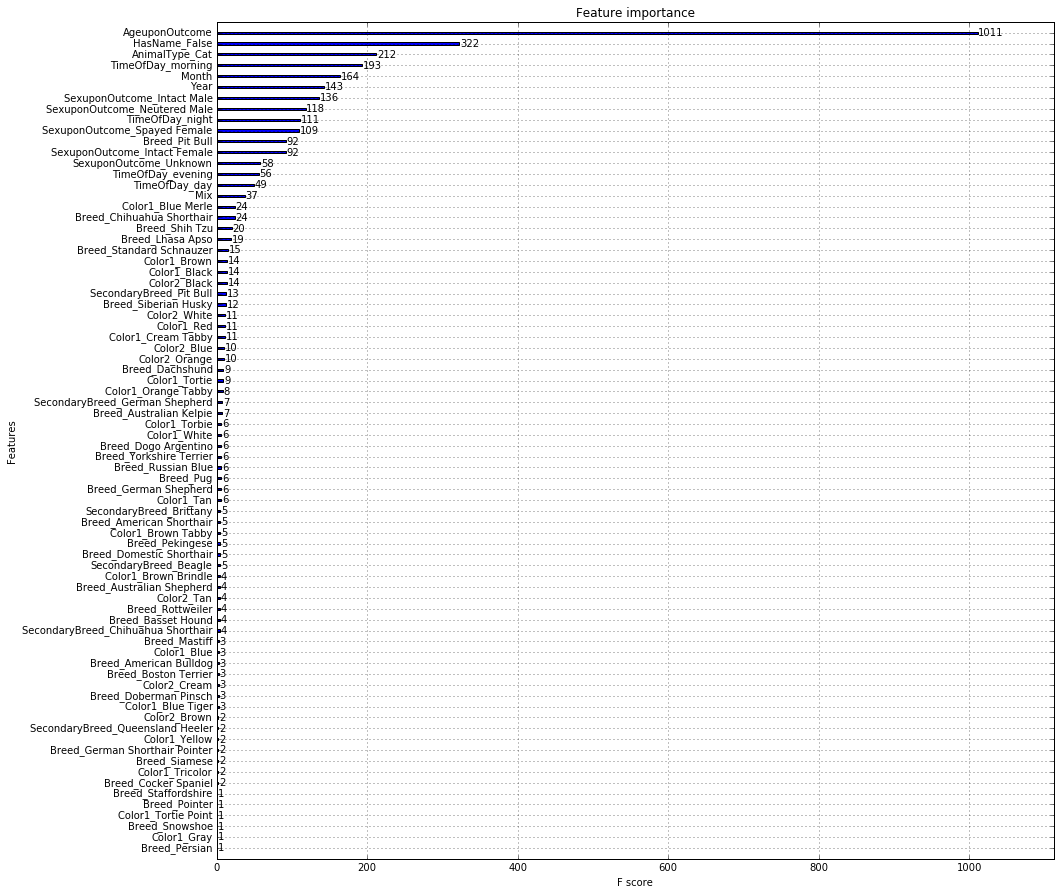

In [160]:
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0)
xgb.plot_importance(cf);